# Chapter 4: Collecting a Displaying Records

In this chapter, our first agile sprint, we climb level 1 of the data-value pyramid (Figure 4-1). We will connect, or plumb, the parts of our data pipeline all the way through from raw data to a web application on a user’s screen. This will enable a single developer to publish raw data records on the web. In doing so, we will activate our stack against our real data, thereby connecting our application to the reality of our data and our users.

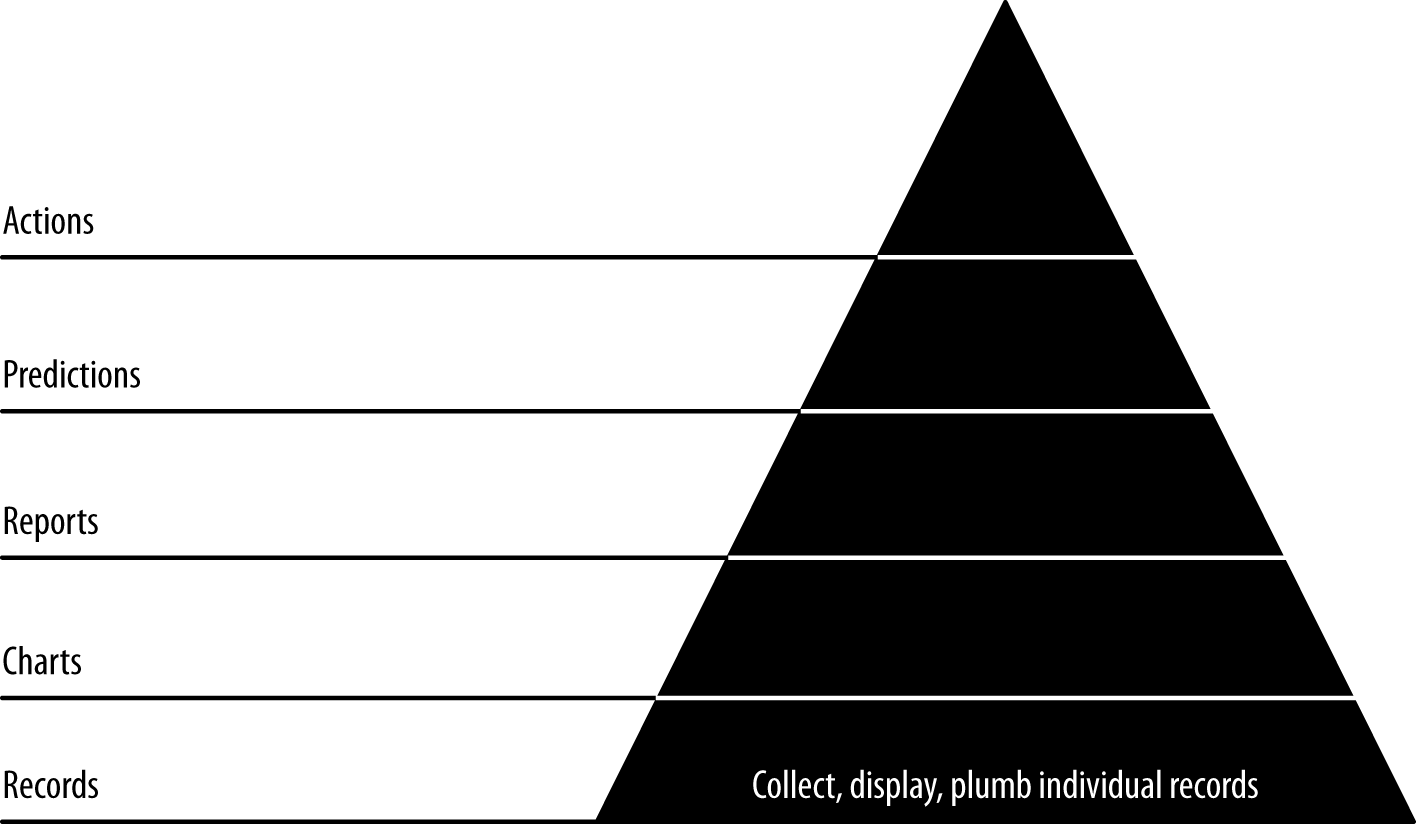

If you already have a popular application, this step may seem confusing in that you already have the individual (or atomic) records displaying in your application. The point of this step, then, is to pipe these records through your analytical pipeline to bulk storage and then on to a browser. Bulk storage provides access for further processing via ETL (extract, transform, load) or some other means.

This first stage of the data-value pyramid can proceed relatively quickly, so we can get on to higher levels of value. Note that we will return to this step frequently as we enrich our analysis with additional datasets. We’ll make each new dataset explorable as we go. We’ll be doing this throughout the book as we work through the higher-level steps. The data-value pyramid is something you step up and down in as you do your analysis and get feedback from users. This setup and these browsable records set the stage for further advances up the data-value pyramid as our complexity and value snowball.

## Putting It All Together

Setting up our stack was a bit of work. The good news is, with this stack, we don’t have to repeat this work as soon as we start to see load from users on our system increase and our stack needs to scale. Instead, we’ll be free to continue to iterate and improve our product from now on.

Now, let’s work with some atomic records—on-time records for each flight originating in the US in 2015—to see how the stack works for us.

_Note: An atomic record is a base record, the most granular of the events you will be analyzing. We might aggregate, count, slice, and dice atomic records, but they are indivisible. As such, they represent ground truth to us, and working with atomic records is essential to plugging into the reality of our data and our application. The point of big data is to be able to analyze the most granular data using NoSQL tools to reach a deeper level of understanding than was previously possible._

## Collecting and Serializing Flight Data

You can see the process of collecting and serializing events in the image below. 

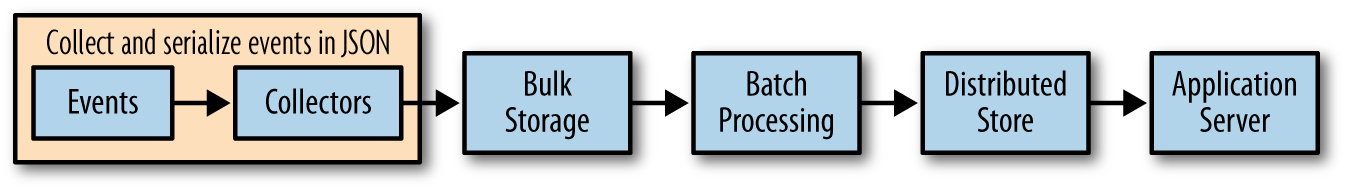

In this case, we have downloaded the core data that we’ll use for the remainder of the book using a script, [download.sh](../download.sh):

```bash
# Get on-time records for all flights in 2015 - 273MB
wget -P data/ \
 http://s3.amazonaws.com/agile_data_science/ \
  On_Time_On_Time_Performance_2015.csv.bz2

# Get openflights data
wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/airports.dat
mv /tmp/airports.dat data/airports.csv

wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/airlines.dat
mv /tmp/airlines.dat data/airlines.csv

wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/routes.dat
mv /tmp/routes.dat data/routes.csv

wget -P /tmp/ \
 https://raw.githubusercontent.com/jpatokal/openflights/ \
  master/data/countries.dat
mv /tmp/countries.dat data/countries.csv

# Get FAA data
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/aircraft.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/ata.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/compt.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/engine.txt
wget -P data/ http://av-info.faa.gov/data/ACRef/tab/prop.txt
```

This has been run before you in advance. You don't have to run it.